<a href="https://colab.research.google.com/github/philschmid/fine-tune-GPT-2/blob/master/Fine_tune_a_non_English_GPT_2_Model_with_Huggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial

In the tutorial, we are going to fine-tune a German GPT-2 from the [Huggingface model hub](https://huggingface.co/models). As fine-tune, data we are using the [German Recipes Dataset](https://www.kaggle.com/sterby/german-recipes-dataset), which consists of 12190 german recipes with metadata crawled from [chefkoch.de](http://chefkoch.de/).

The idea is we use the recipe description to fine-tune our GPT-2 to let us write recipes we can cook.

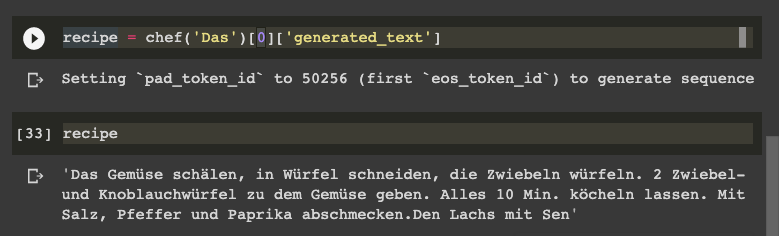

I am using Google Colab with a GPU runtime for this tutorial. If you are not sure how to use a GPU Runtime take a look here.

## **What are we going to do:**

- load the dataset from kaggle
- prepare the dataset and build a ``TextDataset``
- load the pre-trained GPT-2 model and tokenizer
- initialize ``Trainer`` with ``TrainingArguments``
- train and save the model
- test the model

In [ ]:
!pip install transformers==3.1.0

     |████████████████████████████████| 890kB 2.8MB/s 
     |████████████████████████████████| 3.0MB 10.9MB/s 
     |████████████████████████████████| 890kB 27.6MB/s 
     |████████████████████████████████| 1.1MB 43.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=ab422272068497762923868883c7881f36aa70c32886a3c5f1821097674279fe
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
!nvidia-smi

Mon Sep  7 07:40:08 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load the dataset from Kaggle

As already mentioned in the introduction of the tutorial we use the "[German Recipes Dataset](https://www.kaggle.com/sterby/german-recipes-dataset)" dataset from Kaggle. The dataset consists of 12190 german recipes with metadata crawled from [chefkoch.de](http://chefkoch.de/). In this example, we only use the Instructions of the recipes. You can either download the dataset by using the "Download" Button and uploading it to our colab notebook.



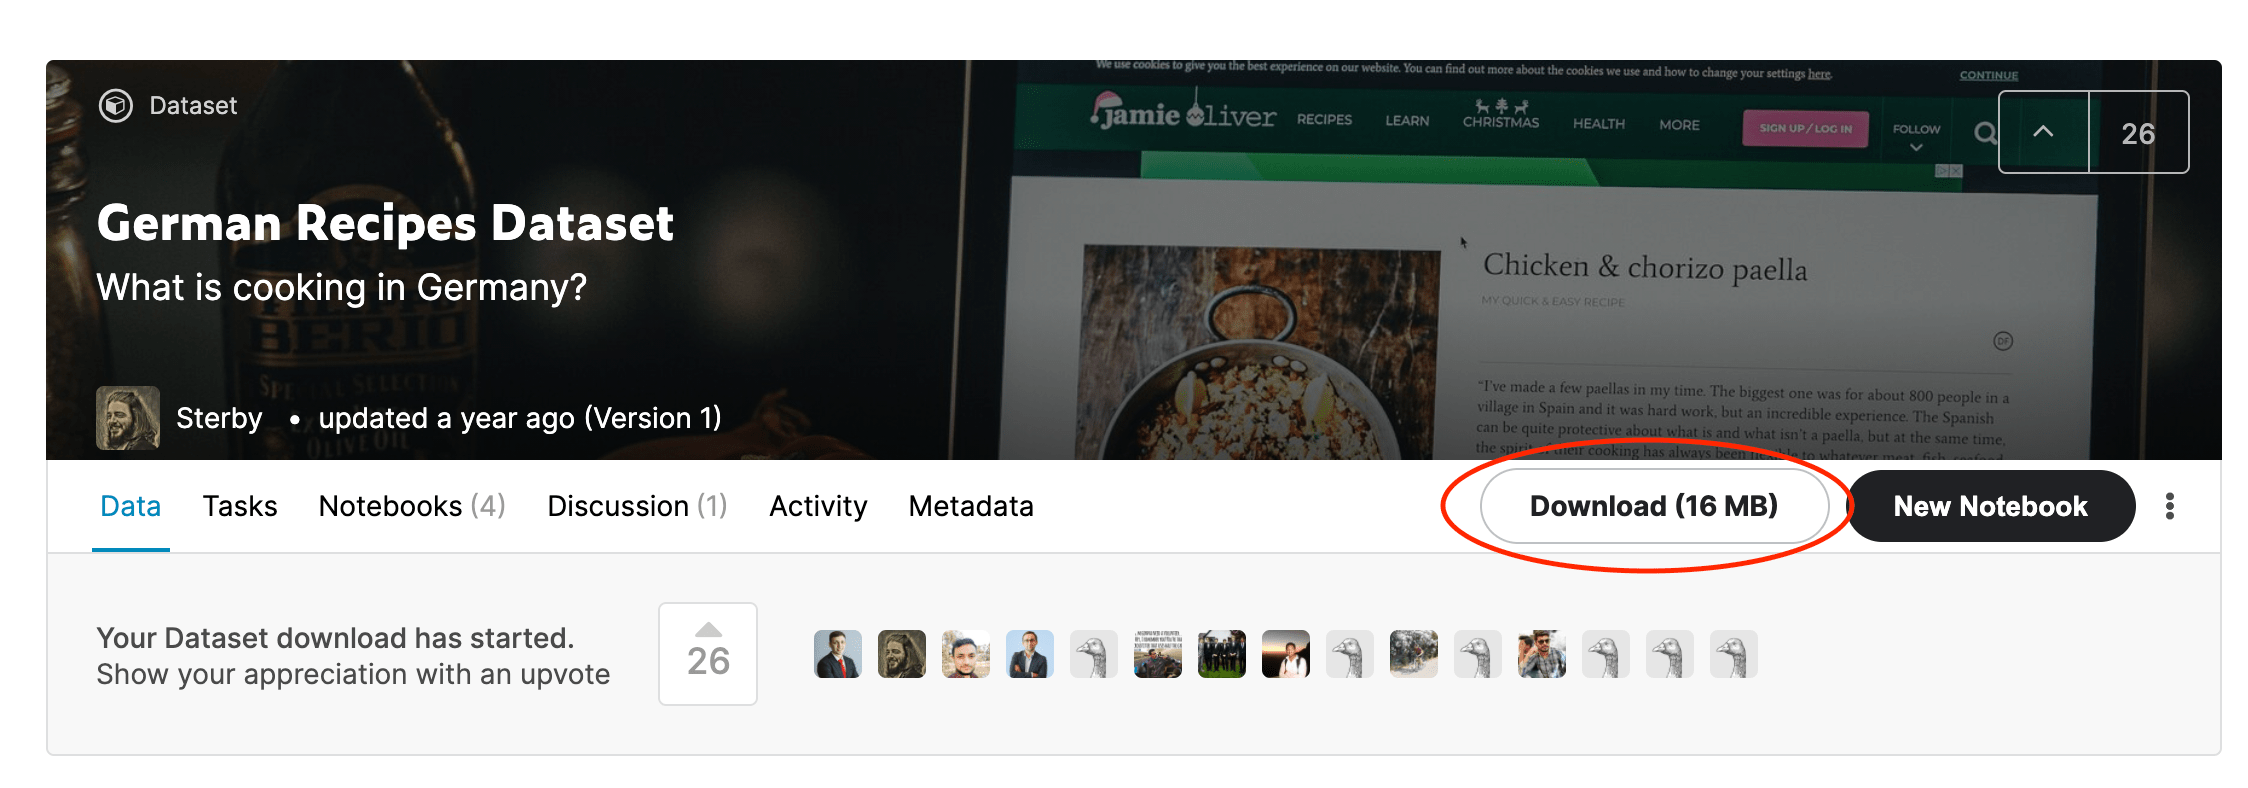

In [ ]:
#upload files to your colab environment
from google.colab import files
uploaded = files.upload()

Saving recipes.json to recipes.json


After we uploaded the file with use `unzip` to extract the recipes.json. 

In [ ]:
!unzip '132879_316218_bundle_archive.zip'

unzip:  cannot find or open 132879_316218_bundle_archive.zip, 132879_316218_bundle_archive.zip.zip or 132879_316218_bundle_archive.zip.ZIP.


# Prepare the dataset and build a ``TextDataset``

The next step is to extract the instructions from all recipes and build a `TextDataset`. The `TextDataset` is a custom implementation of the [Pytroch `Dataset` class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class) implemented by the transformers library. If you want to know more about Dataset in Pytroch you can check out this [youtube video](https://www.youtube.com/watch?v=PXOzkkB5eH0&ab_channel=PythonEngineer).

First, we are going to split the `recipes.json` into a `train` and `test` section and extract `Instructions` from the recipes and write them into a `train_dataset.txt` and `test_dataset.txt`

In [ ]:
import re
import json
from sklearn.model_selection import train_test_split


with open('recipes.json') as f:
    data = json.load(f)

def build_text_files(data_json, dest_path):
    f = open(dest_path, 'w')
    data = ''
    for texts in data_json:
        summary = str(texts['Instructions']).strip()
        summary = re.sub(r"\s", " ", summary)
        data += summary + "  "
    f.write(data)

train, test = train_test_split(data,test_size=0.15) 


build_text_files(train,'train_dataset.txt')
build_text_files(test,'test_dataset.txt')

print("Train dataset length: "+str(len(train)))
print("Test dataset length: "+ str(len(test)))


Train dataset length: 10361
Test dataset length: 1829


the next step is to download the tokenizer, which we use. We use the tokenizer from the `german-gpt2` model on [huggingface](https://huggingface.co/anonymous-german-nlp/german-gpt2).

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("anonymous-german-nlp/german-gpt2")

train_path = 'train_dataset.txt'
test_path = 'test_dataset.txt'

In [ ]:
from transformers import TextDataset,DataCollatorForLanguageModeling

def load_dataset(train_path,test_path,tokenizer):
    train_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=train_path,
          block_size=128)
     
    test_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=test_path,
          block_size=128)   
    
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=False,
    )
    return train_dataset,test_dataset,data_collator

train_dataset,test_dataset,data_collator = load_dataset(train_path,test_path,tokenizer)

# Initialize `Trainer` with `TrainingArguments` and GPT-2 model

The [Trainer](https://huggingface.co/transformers/main_classes/trainer.html#transformers.Trainer) class provides an API for feature-complete training. It is used in most of the [example scripts](https://huggingface.co/transformers/examples.html) from Huggingface. Before we can instantiate our `Trainer` we need to download our GPT-2 model and create a [TrainingArguments](https://huggingface.co/transformers/main_classes/trainer.html#transformers.TrainingArguments) to access all the points of customization during training. In the `TrainingArguments`, we can define the Hyperparameters we are going to use in the training process like our `learning_rate`, `num_train_epochs`, or  `per_device_train_batch_size`. A complete list can you find [here](https://huggingface.co/transformers/main_classes/trainer.html#trainingarguments).

In [ ]:
from transformers import Trainer, TrainingArguments,AutoModelWithLMHead

model = AutoModelWithLMHead.from_pretrained("anonymous-german-nlp/german-gpt2")


training_args = TrainingArguments(
    output_dir="./gpt2-gerchef", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=3, # number of training epochs
    per_device_train_batch_size=32, # batch size for training
    per_device_eval_batch_size=64,  # batch size for evaluation
    eval_steps = 400, # Number of update steps between two evaluations.
    save_steps=800, # after # steps model is saved 
    warmup_steps=500,# number of warmup steps for learning rate scheduler
    )


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    prediction_loss_only=True,
)

/usr/local/lib/python3.6/dist-packages/transformers/modeling_auto.py:821: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


/usr/local/lib/python3.6/dist-packages/transformers/trainer.py:247: FutureWarning: Passing `prediction_loss_only` as a keyword argument is deprecated and won't be possible in a future version. Use `args.prediction_loss_only` instead.
  FutureWarning,


# Train and save the model

To train the model we can simply run `Trainer.train()`.

In [ ]:
trainer.train()

{'loss': 2.84846630859375, 'learning_rate': 5e-05, 'epoch': 1.0101010101010102, 'step': 500}


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


{'loss': 2.183541015625, 'learning_rate': 2.4619289340101523e-05, 'epoch': 2.0202020202020203, 'step': 1000}




TrainOutput(global_step=1485, training_loss=2.3330630523989897)

After training is done you can save the model by calling `save_model()`. This will save the trained model to our `output_dir` from our `TrainingArguments`.

In [ ]:
trainer.save_model()

# Test the model

To test the model we are going to use another [highlight of the transformers library](https://huggingface.co/transformers/main_classes/pipelines.html?highlight=pipelines) called `pipeline`. [Pipelines](https://huggingface.co/transformers/main_classes/pipelines.html?highlight=pipelines) are objects that offer a simple API dedicated to several tasks, among others also `text-generation`

In [ ]:
from transformers import pipeline

chef = pipeline('text-generation',model='./gpt2-gerchef', tokenizer='anonymous-german-nlp/german-gpt2',config={'max_length':800})

#result = chef('Zuerst Hähnchen')[0]['generated_text']


In [ ]:
chef('Die Nudeln Kochen, Fleisch anbraten')

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


[{'generated_text': 'Die Nudeln Kochen, Fleisch anbraten, Tomaten- und Erbsenzehen abgießen, etwas Tomatenmark, Brühepulver und Wein angießen, aufkochen lassen. Tomaten, Erbsenzehen, Tomaten- und Erbsenz'}]

In [ ]:
chef('Zuerst Hähnchen')

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


[{'generated_text': 'Zuerst Hähnchen innen und außen salzen, pfeffern und in Olivenöl kurz anbraten. Mit Pfeffer pfeffern. Anschließend Knoblauch dazu pressen und mit etwas Wasser angießen, so dass die Brühe einen goldbraunen Brä'}]

In [ ]:
chef('Der beste Weg, um einen Schokoladenkuchen zuzubereiten, ist')


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


[{'generated_text': 'Der beste Weg, um einen Schokoladenkuchen zuzubereiten, ist, ihn auf einem Holzspießchen unter fließend kaltem Wasser zu fixieren.Das Ergebnis ist eine knackige Konsistenz der Eier. Eierkuchen schmecken schön knusprig,'}]

In [ ]:
chef('Zuerst Hähnchen')[0]['generated_text']

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


'Zuerst Hähnchen und Zwiebeln in Butter anbraten. Paprika, Paprikastreifen und Tomatenmark zufügen. Brühe hinzugeben und aufkochen. Alles ca. 25 - 30 Minuten köcheln lassen.Die Suppe zum Servieren in'